In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import missingno as msno
import plotly.express as px # plotting geo data
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
import autofeat
import osmnx as ox
import geopandas as gpd

from Own_imputers import PriorityGroupImputer
from OwnFeatEng import feature_engineering, feature_selection, add_geo_features
from OwnDimRed import PCA_num
from PrepData import preprocess

# Train

## Data

In [2]:
data = pd.read_csv("train.csv", header=0)
data = data.drop(columns=['is_promoted','sticker','price_drop_date'])

train, test = train_test_split(data,test_size=0.2, shuffle=True, random_state=42)

In [ ]:
type_map = {
    'energy_label': 'category',
    'postcode': 'category',
    'advertiser' : 'category',
    'province' : 'category', 
    'house_type' : 'category',
    'subtype' : 'category',
    'new_building': 'bool'
}

In [4]:
X_train, X_val, y_train, y_val = train_test_split(train.drop(columns='price'),train['price'], shuffle=True, test_size=0.2, random_state=42)
prep = preprocess(type_map=type_map)
X_train = prep.train(X_train).reset_index(drop=True)
X_val = prep.test(X_val).reset_index(drop=True)

## Feature engineering

In [ ]:
features_init = (['house_type',
             'bedrooms', 'area',
             'new_building', 'lat', 'lon', 'foto_amount',
             'energy_value', 
             'area_miss',  'energy_value_miss'])
# 'province', advertiser','advertiser_miss', 'lat_miss',  'subtype_miss', 'is_appartment', 

### loading geodata

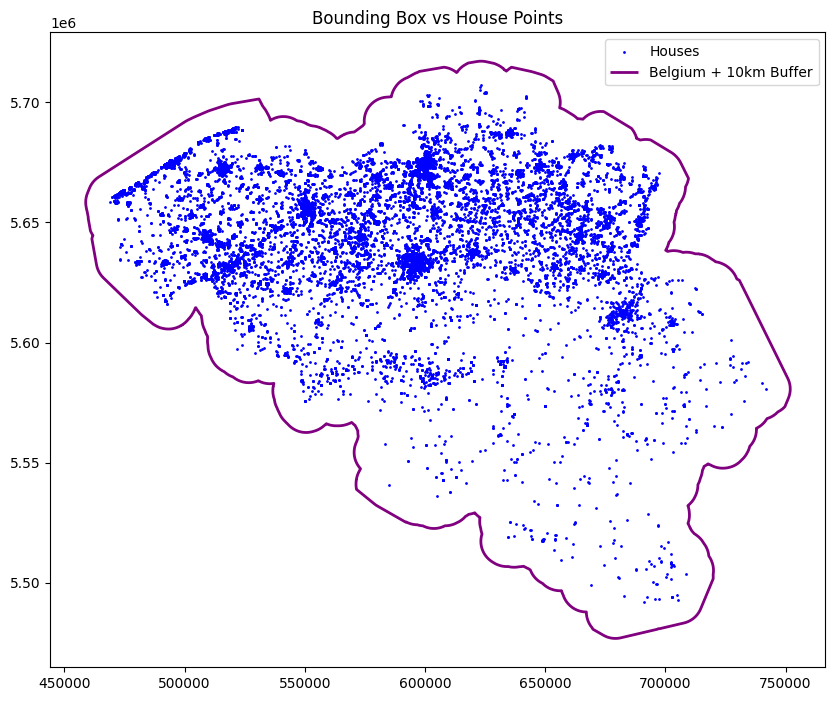

In [6]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, box

# Step 1: Convert to GeoDataFrame
gdf_houses = gpd.GeoDataFrame(
    X_train,
    geometry=[Point(xy) for xy in zip(X_train['lon'], X_train['lat'])],
    crs="EPSG:4326"
)

# Step 2: Project to UTM
utm_crs = gdf_houses.estimate_utm_crs()
gdf_houses = gdf_houses.to_crs(utm_crs)

# Step 3: Define bounding box with buffer

# belgium = ox.geocode_to_gdf("Belgium").to_crs(utm_crs)
# belgium_buffered = belgium.geometry.iloc[0].buffer(10000)
# belgium_buffered_gdf = gpd.GeoDataFrame(geometry=[belgium_buffered], crs=gdf_houses.crs)

# custom_polygon = gdf_houses.union_all().convex_hull.buffer(10000)
# custom_polygon_gdf = gpd.GeoDataFrame(geometry=[custom_polygon], crs=gdf_houses.crs)

# intersection_gdf = gpd.overlay(belgium_buffered_gdf, custom_polygon_gdf, how="intersection")

intersection_gdf = gpd.read_file('intersection_gdf_espg4326.gpkg').to_crs(utm_crs)

# Step 5: Plot
fig, ax = plt.subplots(figsize=(10, 10))
gdf_houses.plot(ax=ax, color='blue', markersize=1, label='Houses')

#belgium_buffered_gdf.boundary.plot(
#     ax=ax, color='green', linewidth=2, label='Belgium + 10km Buffer'
# )
#custom_polygon_gdf.boundary.plot(ax=ax, color='red', linewidth=2, label='Bounding Box')

intersection_gdf.boundary.plot(
    ax=ax, color='purple', linewidth=2, label='Belgium + 10km Buffer'
)
plt.legend()
plt.title("Bounding Box vs House Points")
plt.show()

intersection_gdf_espg4326 = intersection_gdf.to_crs("EPSG:4326").geometry.iloc[0]

In [ ]:
intersection_gdf.area/1e6

0    40752.171982
dtype: float64

In [ ]:
# 1 priority
useamenity = ["restaurant", "fast_food", "cafe", "bar", "pub", 'nightclub' ,'stripclub', 'internet_cafe',
                "college", 'kindergarten', 'library', 'research_institute', 'music_school' , 'school', 'university', 'driving_school', 'traffic_park', 'driver_training',
                'bus_station', 'taxi',
                'bank',
                'clinic', 'dentist ' ,'doctors','hospital','nursing_home', 'pharmacy', 'social_facility', 'veterinary',
                'arts_centre','brothel','casino','cinema','community_centre','conference_centre','events_venue','exhibition_centre','fountain','gambling','music_venue',
                'planetarium','social_centre', 'stage', 'theatre',
                'courthouse', 'fire_station' ,'police', 'prison', 'townhall',
                'crematorium','funeral_hall','grave_yard','mortuary',
                'charging_station', 'fuel']
area_calc = []
tag_amenity = {'amenity': True}
tag_shop = {'shop': True}
tag_leisure = {'leisure': True}
tag_tourism = {'tourism': True}
tag_landuse = {'landuse': True}
tag_natural = {'natural': True}

In [ ]:
# gdf_natural= ox.features.features_from_polygon(intersection_gdf_espg4326, tags=tag_natural) #[['geometry','landuse']]
# gdf_natural[['geometry','natural']].to_file("gdf_natural.gpkg", driver="GPKG")
# print(gdf_natural.head())

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 10))
# gdf_tourism.plot(
#     ax=ax, color='purple', markersize=1
# )
# gdf_houses.to_crs(gdf_tourism.crs).plot(ax=ax, color='blue', markersize=1, label='Houses')
# plt.show()

In [ ]:
# gdf_tourism.to_file("gdf_tourism.gpkg", driver="GPKG")

In [ ]:
# valid_in_any_group = (
#     gdf_landuse.groupby('amenity')
#     .apply(lambda g: ~g.isna().any(), include_groups=False) 
#     .any(axis=0)                       
# )

In [ ]:
# valid_in_any_group

### features from geodata


In [7]:
gdf_leisure = gpd.read_file('gdf_leisure.gpkg')

In [8]:
leisure_features = gdf_leisure.groupby('leisure')['geometry'].count()[(gdf_leisure.groupby('leisure')['geometry'].count()>25)]
print(leisure_features)

leisure
adult_gaming_centre       32
amusement_arcade          61
bandstand                166
barefoot                  44
bird_hide                369
bleachers                145
bowling_alley             74
common                   635
dance                    159
dog_park                 728
escape_game               71
firepit                  120
fishing                  361
fitness_centre           756
fitness_station         1152
garden                 32219
golf_course              250
hackerspace               34
horse_riding             512
marina                   174
miniature_golf           209
nature_reserve          1582
outdoor_seating         1836
park                    7874
picnic_table           11383
pitch                  26571
playground              9921
recreation_ground         77
resort                    56
sauna                    128
schoolyard               275
slipway                  285
sports_centre           4266
sports_hall              451
stadiu

In [ ]:
leisure_features.index.to_list()

['adult_gaming_centre',
 'amusement_arcade',
 'bandstand',
 'barefoot',
 'bird_hide',
 'bleachers',
 'bowling_alley',
 'common',
 'dance',
 'dog_park',
 'escape_game',
 'firepit',
 'fishing',
 'fitness_centre',
 'fitness_station',
 'garden',
 'golf_course',
 'hackerspace',
 'horse_riding',
 'marina',
 'miniature_golf',
 'nature_reserve',
 'outdoor_seating',
 'park',
 'picnic_table',
 'pitch',
 'playground',
 'recreation_ground',
 'resort',
 'sauna',
 'schoolyard',
 'slipway',
 'sports_centre',
 'sports_hall',
 'stadium',
 'swimming_area',
 'swimming_pool',
 'track',
 'water_park']

In [9]:
X_try  = X_train.iloc[:3000]
gdf_houses_espg4326 = gpd.GeoDataFrame(
    X_train,
    geometry=[Point(xy) for xy in zip(X_train['lon'], X_train['lat'])],
    crs="EPSG:4326"
)
tag = 'leisure'
feature_type = 'park'
# add_geo_features(gdf_houses_espg4326, gdf_leisure, tag, feature_type, [500, 1000, 1500, 2000], 10000, True).iloc[:,24:].to_file(f'geofeatures/{tag}_{feature_type}.gpkg', driver='GPKG')

In [12]:
feature_types = leisure_features.index.to_list()
for feature_type in feature_types:
    add_geo_features(gdf_houses_espg4326, gdf_leisure, tag, feature_type, [500, 1000, 1500, 2000], 10000, True).to_parquet(f'geofeatures/{tag}_{feature_type}.parquet')
    print(feature_type)

adult_gaming_centre
amusement_arcade
bandstand
barefoot
bird_hide
bleachers
bowling_alley
common
dance
dog_park
escape_game
firepit
fishing
fitness_centre
fitness_station
garden
golf_course
hackerspace
horse_riding
marina
miniature_golf
nature_reserve
outdoor_seating
park
picnic_table
pitch
playground
recreation_ground
resort
sauna
schoolyard
slipway
sports_centre
sports_hall
stadium
swimming_area
swimming_pool
track
water_park


In [13]:
pd.read_parquet('geofeatures/leisure_fitness_station.parquet')

,closest_leisure*fitness_station,median_leisure*fitness_station_500,median_leisure*fitness_station_1000,median_leisure*fitness_station_1500,median_leisure*fitness_station_2000,mean_leisure*fitness_station_500,mean_leisure*fitness_station_1000,mean_leisure*fitness_station_1500,mean_leisure*fitness_station_2000,count_leisure*fitness_station_500,count_leisure*fitness_station_1000,count_leisure*fitness_station_1500,count_leisure*fitness_station_2000,total_area_leisure*fitness_station_500,total_area_leisure*fitness_station_1000,total_area_leisure*fitness_station_1500,total_area_leisure*fitness_station_2000
0,1332.949010,15000.000000,15000.000000,1366.582200,1400.215391,15000.000000,15000.000000,1366.582200,1502.442880,0.0,0.0,2.0,3.0,0.000000,0.000000,0.000000,0.000000
1,6430.909483,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
2,4354.314576,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,351.150166,438.163613,445.504442,445.504442,445.504442,412.531469,515.279030,515.279030,515.279030,6.0,10.0,10.0,10.0,139.435658,139.435658,139.435658,139.435658
4,780.468808,15000.000000,781.750637,781.750637,781.750637,15000.000000,781.718473,781.718473,781.718473,0.0,3.0,3.0,3.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17319,2734.658807,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
17320,2117.108694,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
17321,2502.990586,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
17322,6253.046914,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000


In [16]:
import os

# Directory containing your GPKG files
df_dir = 'geofeatures'

# Read all GPKG files in the directory
df_list = []
for file in os.listdir(df_dir):
    if file.endswith('.parquet'):
        file_path = os.path.join(df_dir, file)
        df = pd.read_parquet(file_path)
        df_list.append(df)

In [19]:
gdf_houses_espg4326_val = gpd.GeoDataFrame(
    X_val,
    geometry=[Point(xy) for xy in zip(X_val['lon'], X_val['lat'])],
    crs="EPSG:4326"
)
park_features_val =add_geo_features(gdf_houses_espg4326_val, gdf_leisure, 'leisure', 'park', [500, 1000, 1500, 2000], 10000, True)

In [20]:
geofeatcols = park_features.columns[park_features.columns.get_loc('geometry') + 1:].to_list()

In [37]:
gdf_houses_espg4326

,id,is_appartment,area,added_time,bedrooms,new_building,postcode,lat,lon,advertiser,...,mean_leisure*park_1500,mean_leisure*park_2000,count_leisure*park_500,count_leisure*park_1000,count_leisure*park_1500,count_leisure*park_2000,total_area_leisure*park_500,total_area_leisure*park_1000,total_area_leisure*park_1500,total_area_leisure*park_2000
0,tr21948,True,107.0,141806136,2.0,True,3620,50.888850,5.651483,SOM Vastgoed Hasselt,...,497.412045,497.412045,3.0,5.0,5.0,5.0,37221.985727,45281.124413,45281.124413,4.528112e+04
1,tr15540,True,90.0,141038038,2.0,False,8430,51.191350,2.823433,Agence Depoorter,...,1066.971005,1465.164911,0.0,1.0,2.0,4.0,0.000000,26937.995343,92010.325911,3.639307e+05
2,tr11197,False,200.0,139648778,4.0,False,6940,50.401414,5.512796,ERA B-Lux (Marche-en-Famenne),...,15000.000000,15000.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00
3,tr15297,False,146.0,141426108,3.0,False,8800,50.947936,3.112553,Axelle THIERY,...,943.170146,1274.776658,5.0,9.0,19.0,33.0,153130.587449,196691.197834,238028.559800,2.665704e+05
4,tr26678,False,285.0,128499149,6.0,False,7700,50.745380,3.211730,GM Immobilier Mouscron,...,582.470984,855.729988,5.0,12.0,14.0,18.0,25099.686342,256666.055241,259509.570633,2.691056e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17319,tr4218,True,147.0,141903565,2.0,False,8530,50.863602,3.320392,Office Kortrijk,...,1211.286509,1312.570153,0.0,2.0,8.0,10.0,0.000000,9222.231347,253005.611763,2.077745e+06
17320,tr20227,False,202.0,141779793,3.0,False,8800,50.965960,3.136044,Domicill Vastgoed,...,1189.549700,1519.241066,0.0,2.0,8.0,20.0,0.000000,4977.612815,61798.912776,1.589993e+05
17321,tr19077,False,280.0,133687099,4.0,False,3650,51.033560,5.695940,N78 vastgoed,...,15000.000000,1946.612326,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,6.661081e+04
17322,tr20956,False,117.0,142122287,3.0,False,1755,50.791980,4.084318,Makelaarskantoor De Smet BV,...,926.628687,1197.000086,1.0,2.0,4.0,6.0,1598.169525,1876.707488,2457.146516,1.218365e+04


In [33]:
park_features.iloc[:,24:]

,geometry,closest_leisure*park,median_leisure*park_500,median_leisure*park_1000,median_leisure*park_1500,median_leisure*park_2000,mean_leisure*park_500,mean_leisure*park_1000,mean_leisure*park_1500,mean_leisure*park_2000,count_leisure*park_500,count_leisure*park_1000,count_leisure*park_1500,count_leisure*park_2000,total_area_leisure*park_500,total_area_leisure*park_1000,total_area_leisure*park_1500,total_area_leisure*park_2000
0,POINT (5.65148 50.88885),173.660755,269.061816,352.786330,352.786330,352.786330,265.169634,497.412045,497.412045,497.412045,3.0,5.0,5.0,5.0,37221.985727,45281.124413,45281.124413,4.528112e+04
1,POINT (2.82343 51.19135),650.108295,15000.000000,650.108295,1066.971005,1664.737697,15000.000000,650.108295,1066.971005,1465.164911,0.0,1.0,2.0,4.0,0.000000,26937.995343,92010.325911,3.639307e+05
2,POINT (5.5128 50.40141),2626.593145,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000e+00
3,POINT (3.11255 50.94794),268.886877,396.617183,478.925912,1069.689834,1464.999024,369.128531,523.404804,943.170146,1274.776658,5.0,9.0,19.0,33.0,153130.587449,196691.197834,238028.559800,2.665704e+05
4,POINT (3.21173 50.74538),167.767417,181.216337,524.546292,536.844683,705.193680,220.750428,472.232833,582.470984,855.729988,5.0,12.0,14.0,18.0,25099.686342,256666.055241,259509.570633,2.691056e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17319,POINT (3.32039 50.8636),693.714894,15000.000000,824.369432,1335.544192,1379.513390,15000.000000,824.369432,1211.286509,1312.570153,0.0,2.0,8.0,10.0,0.000000,9222.231347,253005.611763,2.077745e+06
17320,POINT (3.13604 50.96596),673.888941,15000.000000,732.914301,1269.496277,1564.710903,15000.000000,732.914301,1189.549700,1519.241066,0.0,2.0,8.0,20.0,0.000000,4977.612815,61798.912776,1.589993e+05
17321,POINT (5.69594 51.03356),1946.612326,15000.000000,15000.000000,15000.000000,1946.612326,15000.000000,15000.000000,15000.000000,1946.612326,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,6.661081e+04
17322,POINT (4.08432 50.79198),186.856221,186.856221,462.146997,1063.938380,1391.110378,186.856221,462.146997,926.628687,1197.000086,1.0,2.0,4.0,6.0,1598.169525,1876.707488,2457.146516,1.218365e+04


### New own features

In [ ]:
# from OwnFeatEng import SpecialTransform

# new_cols = SpecialTransform(X_train).columns.to_list()
# X_train = X_train.join(SpecialTransform(X_train))
# X_val = X_val.join(SpecialTransform(X_val))

In [ ]:
# cl_range = list(range(20,101,20)) + list(range(150,301,50))
# feateng = feature_engineering(targets=['area', 'bedrooms','energy_value'],
#                               transform_type=['median'],
#                               comp_type=['diff'],
#                               groups=['province','house_type'],
#                               features=['lat','lon'],
#                               cl_name='clt',
#                               clustering=True, 
#                               cluster_range=cl_range)

# feateng_density = feature_engineering(targets=['area'],
#                               transform_type=['count'],
#                               comp_type=None,
#                               groups=['province','house_type'],
#                               features=['lat','lon'],
#                               cl_name='clt',
#                               clustering=False, 
#                               cluster_range=cl_range)

# X_train_new = feateng.train(X_train)
# X_val_new = feateng.test(X_val)


# X_train_new = feateng_density.train(X_train_new)
# X_val_new = feateng_density.test(X_val_new)

In [ ]:
# X_train_new.columns

Index(['id', 'is_appartment', 'area', 'added_time', 'bedrooms', 'new_building',
       'postcode', 'lat', 'lon', 'advertiser',
       ...
       'area-clt40-count', 'area-clt60-count', 'area-clt80-count',
       'area-clt100-count', 'area-clt150-count', 'area-clt200-count',
       'area-clt250-count', 'area-clt300-count', 'area-province-count',
       'area-house_type-count'],
      dtype='object', length=110)

In [ ]:
# features_new = X_train_new.columns.to_list()[24:]
# print(len(features_new))

86


### Feature selection on correlation

In [14]:
def getnum(df):
    logic = (df.dtypes=='float64') | (df.dtypes=='float32') | (df.dtypes=='float16')
    num_features = df.dtypes[logic].index.to_list()
    other_features = df.dtypes[~logic].index.to_list()
    return num_features, other_features

In [16]:
# plt.figure(figsize=(8, 6))
# sns.heatmap(spearman_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Spearman Correlation Matrix')
# plt.show()

In [ ]:
numcols, othcols = getnum(X_train_new)
catcols = ['new_building',
 'advertiser',
 'subtype',
 'house_type',
 'area_miss',
 'lat_miss',
 'advertiser_miss',
 'subtype_miss',
 'energy_label_miss',
 'clt20',
 'clt40',
 'clt60',
 'clt80',
 'clt100',
 'clt150',
 'clt200',
 'clt250',
 'clt300']

numcols = numcols + (
['miss_tot',
 'area-clt20-count',
 'area-clt40-count',
 'area-clt60-count',
 'area-clt80-count',
 'area-clt100-count',
 'area-clt150-count',
 'area-clt200-count',
 'area-clt250-count',
 'area-clt300-count',
 'area-province-count',
 'area-house_type-count' ])

In [ ]:
# only_cor = feature_selection()
# selected, _ = only_cor.select(X_train_new[numcols])

In [ ]:
# items_to_remove = {'index', 'id', 'is_appartment', 'added_time', 'postcode', 'energy_label', 'province', 'bedrooms_cat', 'lon_miss' ,'energy_value_miss'}
# othcols = [x for x in othcols if x not in items_to_remove]
# features_filt = catcols+selected

### MI scores

In [ ]:
# from OwnFeatEng import make_mi_scores, plot_mi_scores
# mi_scores = make_mi_scores(X_train_new_new[features_new],y_train.reset_index(drop=True))
# plot_mi_scores(mi_scores)

### Autofeat

In [ ]:
# X_train_new = X_train_new[catcols + numcols]
# X_val_new = X_val_new[catcols + numcols]

In [ ]:
# categorical_cols=['house_type', 'lat_miss',  'clt20', 'clt40', 'clt60', 'clt80', 'clt100', 'clt150', 'clt200', 'clt250', 'clt300']
# feateng_cols=['area', 'energy_value', 'bedrooms', 'foto_amount']

# autofeatures = autofeat.AutoFeatRegressor(feateng_cols=feateng_cols, featsel_runs=2)
# X_train_feat = autofeatures.fit_transform(X_train_new[feateng_cols], np.log(y_train.reset_index(drop=True))).drop(columns=feateng_cols)
# X_val_feat = autofeatures.transform(X_val_new[feateng_cols]).drop(columns=feateng_cols)

# X_train_new = X_train_new.join(X_train_feat)
# X_val_new = X_val_new.join(X_val_feat)

## Dimensionality Reduction

### PCA

In [ ]:
# pca_own = PCA_num(n_components=100)
# X_train_red = pca_own.fit_transform(X_train_new_new)

## Model

### KNN

In [100]:
# X_train, y_train = train[['is_appartment','area','lat','lon','foto_amount','energy_value','house_type']].copy(),train['price'].copy()

# X_train_encoded = pd.get_dummies(X_train, columns=['house_type'])

# scaler = StandardScaler()
# X_train_encoded[['area','lat','lon','energy_value','foto_amount']] = scaler.fit_transform(X_train_encoded[['area','lat','lon','energy_value','foto_amount']])

In [101]:
# scores_KNN = []
# for i in range(2,60,2):
#     neigh_model = KNeighborsRegressor(n_neighbors=i, weights='distance')
#     scores_KNN.append(cross_val_score(neigh_model, X_train_encoded, y_train, cv=5, scoring='neg_mean_absolute_percentage_error')*-1)

# scores_KNN = pd.DataFrame(scores_KNN)
# plt.scatter((scores_KNN.index+1)*2, scores_KNN.apply(np.mean, axis=1))

In [102]:
# neigh_model_final = KNeighborsRegressor(n_neighbors=14, weights='distance')
# neigh_model_final.fit(X_train_encoded,y_train)

### XGBoost

In [21]:
features_init = (['is_appartment',
 'area',
 'bedrooms',
 'new_building',
 'lat',
 'lon',
#  'advertiser',
 'foto_amount',
#  'subtype',
 'energy_value',
#  'province',
 'house_type',
 'area_miss',
 'lat_miss',
 'advertiser_miss',
#  'subtype_miss',
 'energy_value_miss'])

geofeatcols = (
['closest_leisure*park',
 'median_leisure*park_500',
 'median_leisure*park_1000',
 'median_leisure*park_1500',
 'median_leisure*park_2000',
#  'mean_leisure*park_500',
#  'mean_leisure*park_1000',
#  'mean_leisure*park_1500',
#  'mean_leisure*park_2000',
 'count_leisure*park_500',
 'count_leisure*park_1000',
 'count_leisure*park_1500',
 'count_leisure*park_2000',
 'total_area_leisure*park_500',
 'total_area_leisure*park_1000',
 'total_area_leisure*park_1500',
 'total_area_leisure*park_2000'])

In [22]:
#X_train, X_val, y_train, y_val = train_test_split(train[features],train['price'], shuffle=False, test_size=0.2)
features_model = (features_init
                #+features_new
                +geofeatcols
)

dtrain = xgb.DMatrix(park_features[features_model], label=y_train.reset_index(drop=True), enable_categorical=True)
dval = xgb.DMatrix(park_features_val[features_model],label=y_val.reset_index(drop=True), enable_categorical=True)

evallist = [(dval, 'val')]
param_xgb = {'max_depth': 6, 'eta': 0.05, 'objective': 'reg:squarederror', 'reg_lambda':10, 'reg_alpha':10, 'eval_metric': 'rmse',}

xgb_regressor = xgb.train(
    params=param_xgb,
    dtrain=dtrain,
    num_boost_round=2000,
    evals=evallist,
    early_stopping_rounds=50
)

xgb_regressor = xgb.train(
    params=param_xgb,
    dtrain=dtrain,
    num_boost_round=xgb_regressor.best_iteration + 1, 
    evals=evallist
)

# RMSE = np.mean((np.exp(xgb_regressor.predict(dval))-y_val)**2)**(1/2)
# print(RMSE)
xgb_regressor.eval(dval)

[0]	val-rmse:171809.43464
[1]	val-rmse:167951.29261
[2]	val-rmse:164359.65017
[3]	val-rmse:161047.93756
[4]	val-rmse:157973.21393
[5]	val-rmse:155083.74201
[6]	val-rmse:152429.19832
[7]	val-rmse:149881.90137
[8]	val-rmse:147604.89569
[9]	val-rmse:145372.26162
[10]	val-rmse:143264.07621
[11]	val-rmse:141358.41516
[12]	val-rmse:139517.11777
[13]	val-rmse:137831.64308
[14]	val-rmse:136228.73770
[15]	val-rmse:134791.29044
[16]	val-rmse:133398.10478
[17]	val-rmse:132118.99542
[18]	val-rmse:130923.12279
[19]	val-rmse:129845.72468
[20]	val-rmse:128795.64345
[21]	val-rmse:127761.70753
[22]	val-rmse:126680.17091
[23]	val-rmse:125861.09568
[24]	val-rmse:124896.93285
[25]	val-rmse:124046.67127
[26]	val-rmse:123283.23866
[27]	val-rmse:122592.92422
[28]	val-rmse:121957.50675
[29]	val-rmse:121424.73822
[30]	val-rmse:120819.92938
[31]	val-rmse:120254.54053
[32]	val-rmse:119690.64202
[33]	val-rmse:119193.52970
[34]	val-rmse:118663.03626
[35]	val-rmse:118170.09046
[36]	val-rmse:117760.01207
[37]	val-rm

'[0]\teval-rmse:100848.84648255082720425'

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

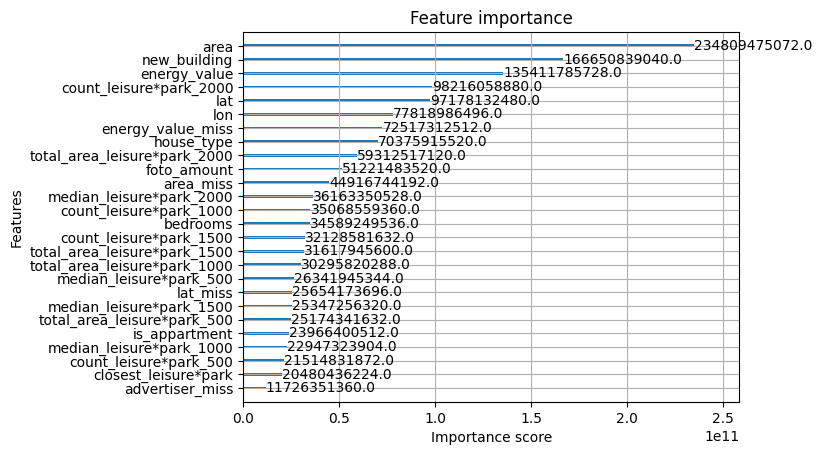

In [23]:
xgb.plot_importance(xgb_regressor, importance_type='gain')

# Test

## Data

In [25]:
# test = pd.read_csv("test.csv", header=0)
test = test.reset_index()
# test = test.drop(columns=['is_promoted','sticker','price_drop_date'])
test['energy_label'] = test['energy_label'].astype('category')
test['new_building'] = test['new_building'].astype('bool')
test['postcode'] = test['postcode'].astype('category')

test['bedrooms_cat'] = pd.cut(test['bedrooms'], bins=[-1,0,1,2,3,4,5,6,float('inf')], labels=['0','1','2','3','4','5','6','7+'])
test['house_type'] = test['subtype'].apply(categorize_house)

## KNN

In [ ]:
# X_test = test[['is_appartment','area','lat','lon','foto_amount','energy_value','house_type']].copy()

# X_test_encoded = pd.get_dummies(X_test, columns=['house_type'])

# scaler = StandardScaler()
# X_test_encoded[['area','lat','lon','energy_value','foto_amount']] = scaler.fit_transform(X_test_encoded[['area','lat','lon','energy_value','foto_amount']])
# X_test_encoded.isna().apply(sum)
# y_test = test['price'].copy()
# y_pred_test = neigh_model_final.predict(X_test_encoded)

## XGBoost

## Error bars

In [615]:
mean_error_1=(y_pred_test/y_test-1).mean()
error_bound_1 = (y_pred_test/y_test-1).std()/len(y_pred_test)**(1/2)*1.96

mean_error_2=abs(y_pred_test/y_test-1).mean()
error_bound_2 = abs(y_pred_test/y_test-1).std()/(len(y_pred_test)**(1/2))*1.96

mean_error_3=((y_pred_test-y_test)**2).mean()**(1/2)
error_bound_3 = abs(y_pred_test-y_test).std()/(len(y_pred_test)**(1/2))*1.96

# Submission metrics

In [510]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=y_pred_test*(1-mean_error_1-error_bound_1)
y_pred_final['upper']=y_pred_test*(1-mean_error_1+error_bound_1)
y_pred_final['pred']=y_pred_test*(1-mean_error_1)

y_pred_final.to_csv(f"xgb_simple_1.csv", index=False)

In [513]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=y_pred_test*(1-mean_error_2-error_bound_2)
y_pred_final['upper']=y_pred_test*(1+mean_error_2+error_bound_2)
y_pred_final['pred']=y_pred_test

y_pred_final.to_csv(f"xgb_simple_2.csv", index=False)

In [512]:
y_pred_final = pd.DataFrame()
y_pred_final['id']=test['id']
y_pred_final['lower']=np.maximum(y_pred_test-mean_error_3-error_bound_3,0)
y_pred_final['upper']=y_pred_test+mean_error_3+error_bound_3
y_pred_final['pred']=y_pred_test

y_pred_final.to_csv(f"xgb_simple_3.csv", index=False)